<a href="https://colab.research.google.com/github/jcmachicao/curso_intro_nn/blob/main/uc_captum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install captum

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import math
import plotly.express as px

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ruta = 'drive/My Drive/00 Modelos Principales/mod__uc_ret_2022/experimento_v10/'

In [ ]:
ncols, ncats, tipo_modelo = 37, 2, 'clasificación'

In [ ]:
# Arquitectura de Clasificación
class NetClas(nn.Module):

  def __init__(self):
    super(NetClas, self).__init__()
    self.fc1 = nn.Linear(ncols, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 32)
    self.fc4 = nn.Linear(32, ncats)
    self.dp1 = nn.Dropout(0.15)

  def forward(self, x):
    x = self.dp1(F.relu(self.fc1(x)))
    x = self.dp1(F.relu(self.fc2(x)))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return F.log_softmax(x, dim=1)

if tipo_modelo == 'regresión':
  model = NetReg()
else:
  model = NetClas()

print(model)
print(tipo_modelo)

NetClas(
  (fc1): Linear(in_features=37, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
  (dp1): Dropout(p=0.15, inplace=False)
)
clasificación


In [ ]:
model.load_state_dict(torch.load(ruta + 'modelo_mod_RET_CLA_v10_kpi_0.pth', map_location=torch.device('cpu')))
print("Modelo cargado.")

Modelo cargado.


In [ ]:
X_np = np.load(ruta + 'X_np_RET_v10.npy')
y_np = np.load(ruta + 'y_np_RET_v10.npy')
X_np.shape, y_np.shape

((6714, 37), (6714,))

In [ ]:
X_t_s = torch.tensor(X_np).float()
out = model(X_t_s)
y_hat = torch.argmax(out.detach(), 1).numpy()
y_hat

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
pd.Series(y_hat).value_counts()

1    5239
0    1475
dtype: int64

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [ ]:
ig = IntegratedGradients(model)

In [ ]:
X_t_s.requires_grad_()

tensor([[0.1199, 0.3004, 0.1242,  ..., 0.0000, 0.0000, 0.6625],
        [0.3390, 0.4751, 0.4132,  ..., 1.0000, 0.0000, 0.5837],
        [0.1013, 0.1887, 0.1478,  ..., 0.0000, 0.0000, 0.5447],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1335],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0252],
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0384]],
       requires_grad=True)

In [ ]:
attr, delta = ig.attribute(X_t_s.float(), target=1, return_convergence_delta=True) 
# para un modelo 6k x 512x6layers clas demora aproximadamente 20 min

In [ ]:
attr = attr.detach().numpy()

In [ ]:
importancias = np.mean(attr, axis=0)
len(importancias)

37

In [ ]:
cols = pd.read_csv(ruta + 'cols.csv')
cols_list = list(cols.columnas)
cols_list

In [ ]:
for i in range(len(cols_list)):
    print(cols_list[i], ": ", '%.3f'%(importancias[i]))
x_pos = (np.arange(len(cols_list)))
x_pos

ms16_A :  -0.436
mt16_A :  0.004
mvars1s6_A :  -0.198
mvart1t6_A :  0.047
ms16_B :  1.361
mt16_B :  1.273
mvars1s6_B :  -0.047
mvart1t6_B :  -0.071
Per_adm_202110 :  -0.901
ead :  3.742
c_aqp :  0.016
c_cus :  0.151
c_hyo :  0.237
c_lim :  0.004
adm :  0.236
adm_gp :  0.056
conta :  0.042
derecho :  -0.373
ing_civ :  -0.065
ing_min :  -0.050
ing_sis :  0.137
ing_elec :  0.061
ing_emp :  -0.042
ing_ind :  0.397
ing_mec :  0.122
psico :  0.246
genero2 :  -0.151
casado :  0.285
conviv :  0.217
solter :  1.308
dep_si :  -1.036
e_atecnica :  0.178
e_auniversitaria :  -0.098
dias7 :  1.770
dias56 :  0.236
dias34 :  -0.011
edad :  -2.092


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36])

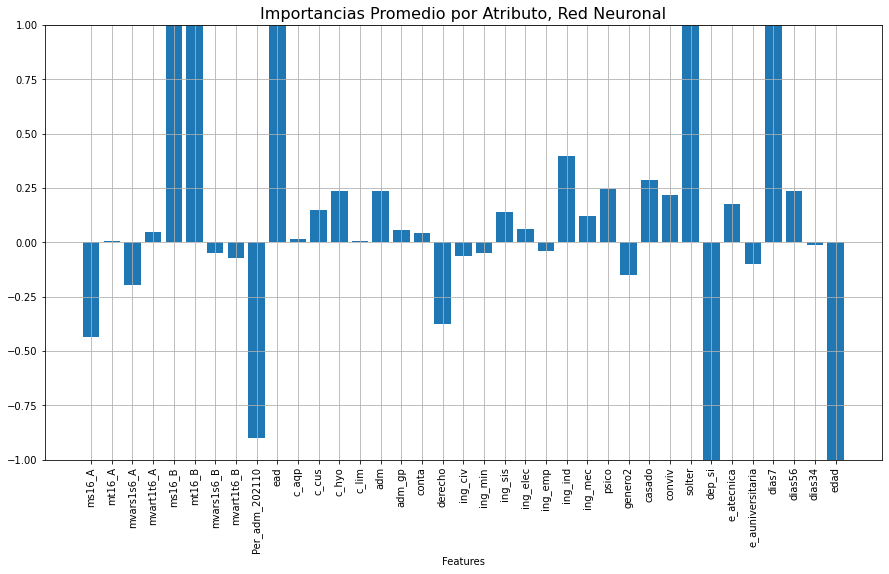

In [ ]:
plt.figure(figsize=(15,8))
plt.bar(x_pos, importancias)
plt.xticks(x_pos, cols_list)
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.title('Importancias Promedio por Atributo, Red Neuronal', fontsize=16)
plt.ylim(-1,1)
plt.grid(True)
plt.show()